# Cenário Reduzido

Iniciando a simulação de Monte Carlo (Cenário Reduzido)...
Parâmetros: M=16, K=3, N_rx=8, N_tx=4, Área=100m, Realizações=1000
Multipath: Canal Rician (K=3.0 dB) para Comunicação.
Calibração: RCS Gain=92.0 dB.
Simulando alocação de potência: 90/10
  Realização 100/1000
  Realização 100/1000
  Realização 200/1000
  Realização 200/1000
  Realização 300/1000
  Realização 300/1000
  Realização 400/1000
  Realização 400/1000
  Realização 500/1000
  Realização 500/1000
  Realização 600/1000
  Realização 600/1000
  Realização 700/1000
  Realização 700/1000
  Realização 800/1000
  Realização 800/1000
  Realização 900/1000
  Realização 900/1000
  Realização 1000/1000
Simulando alocação de potência: 50/50
  Realização 1000/1000
Simulando alocação de potência: 50/50
  Realização 100/1000
  Realização 100/1000
  Realização 200/1000
  Realização 200/1000
  Realização 300/1000
  Realização 300/1000
  Realização 400/1000
  Realização 400/1000
  Realização 500/1000
  Realização 500/1000
  Realização 60

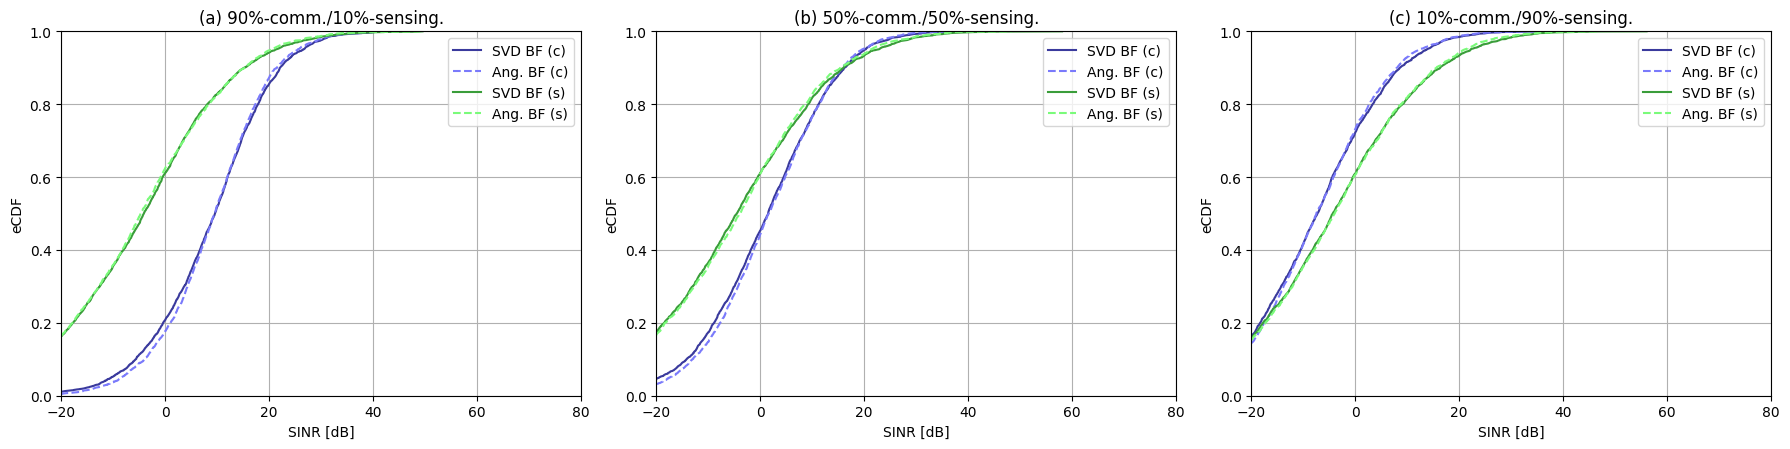

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm
from numpy.linalg import svd, norm as l2norm
import warnings

#  1. Parâmetros da Simulação

M = 16         # Número de APs
K = 3          # Número de UEs
L = 1          # Número de Alvos
N_rx = 8       # Antenas por AP
N_tx = 4       # Antenas por UE

# Geometria
AREA_SIZE = 100  # Área de 100x100 m^2
H_AP = 11.5    # Altura do AP [m]
H_UE = 1.5     # Altura do UE [m]
H_TGT = 0.0    # Altura do Alvo [m]
AP_GRID_N = int(np.sqrt(M)) # APs em uma grade 4x4
AP_SPACING = AREA_SIZE / (AP_GRID_N - 1) if AP_GRID_N > 1 else 0

# Tamanho do cluster de sensoriamento
M_SENSING = 4

# Ganho de RCS
RCS_GAIN_DB = 92.0
RCS_GAIN_LINEAR = 10**(RCS_GAIN_DB / 10)

# Multipath para o Canal de Comunicação
# Fator Rician K (Potência LoS / Potência NLoS)
RICIAN_K_FACTOR_DB = 3.0

# Parâmetros de RF e Potência
F_C = 1.9e9      # Frequência da portadora (1.9 GHz)
BW = 20e6        # Largura de banda (20 MHz)
P_TOTAL_DBM = 24 # Potência total do UE [dBm]
P_TOTAL_W = 10**((P_TOTAL_DBM - 30) / 10) # Potência total em Watts
NOISE_FIGURE_DB = 9 # Figura de ruído [dB]
TEMP_K = 298       # Temperatura [K]
BOLTZMANN_K = 1.380649e-23

# Cálculo da Potência de Ruído
NOISE_FIGURE = 10**(NOISE_FIGURE_DB / 10)
NOISE_POWER_W = BOLTZMANN_K * TEMP_K * BW * NOISE_FIGURE
SIGMA_N2 = NOISE_POWER_W

# Parâmetros do Canal e Simulação
SHADOWING_STD_DB = 8.0 # Desvio padrão do sombreamento [dB]
N_REALIZATIONS = 1000  # 1000 realizações de Monte Carlo
SIGMA_RCS_2 = 1.0      # Variância do RCS (Swerling-I)

# Distribuições de potência
POWER_SPLITS = {
    "90/10": (0.9, 0.1),
    "50/50": (0.5, 0.5),
    "10/90": (0.1, 0.9)
}

# 2. Funções Auxiliares (Modelos Físicos)

def calculate_3d_distance(pos1, pos2):
    return np.sqrt(np.sum((np.array(pos1) - np.array(pos2))**2))

def get_angles(tx_pos, rx_pos):
    tx_pos, rx_pos = np.array(tx_pos), np.array(rx_pos)
    delta = rx_pos - tx_pos
    dist_xy = np.sqrt(delta[0]**2 + delta[1]**2)

    if dist_xy == 0:
        theta = 0.0
    else:
        theta = np.arctan2(delta[1], delta[0]) # Azimute

    dist_3d = l2norm(delta)
    if dist_3d == 0 or np.isclose(dist_3d, 0):
        phi = 0.0
    else:
        asin_arg = np.clip(delta[2] / dist_3d, -1.0, 1.0)
        phi = np.arcsin(asin_arg) # Elevação

    return theta, phi

def get_steering_vector(theta, phi, N_antennas):
    n = np.arange(N_antennas)
    spatial_freq = np.sin(phi) * np.cos(theta)
    vec = (1 / np.sqrt(N_antennas)) * np.exp(-1j * np.pi * n * spatial_freq)
    return vec.reshape(N_antennas, 1)

def get_path_loss_shadowing(dist_3d, h_1, h_2):
    dist_2d = np.sqrt(max(0, dist_3d**2 - (h_1 - h_2)**2))
    f_ghz = F_C / 1e9

    if dist_2d < 10:
        dist_2d = 10

    pl_db = 28.0 + 22 * np.log10(dist_2d) + 20 * np.log10(f_ghz)

    shadowing = np.random.normal(0, SHADOWING_STD_DB)
    pl_total_db = pl_db + shadowing

    beta = 10**(-pl_total_db / 10)
    return beta

def create_rician_channel(tx_pos, rx_pos, N_tx, N_rx, beta, rician_k_db):
    """
    Cria um canal Rician (LoS + Multipath NLoS)
    """
    K_lin = 10**(rician_k_db / 10)

    # 1. Componente LoS (Geométrico)
    aod_theta, aod_phi = get_angles(tx_pos, rx_pos)
    a_tx = get_steering_vector(aod_theta, aod_phi, N_tx)
    aoa_theta, aoa_phi = get_angles(rx_pos, tx_pos)
    a_rx = get_steering_vector(aoa_theta, aoa_phi, N_rx)
    H_los = a_rx @ a_tx.conj().T

    # 2. Componente NLoS (Multipath aleatório, modelo Rayleigh)
    H_nlos = (np.random.randn(N_rx, N_tx) + 1j * np.random.randn(N_rx, N_tx)) / np.sqrt(2)

    # 3. Combinar com fator Rician K e aplicar a perda de percurso total (beta)
    H = np.sqrt(beta) * (np.sqrt(K_lin / (K_lin + 1)) * H_los +
                        np.sqrt(1 / (K_lin + 1)) * H_nlos)
    return H

#  3. Funções de Beamforming

def get_svd_beamforming(H_effective):
    if H_effective is None or H_effective.shape[0] == 0:
        w_bf = np.zeros((N_tx, 1), dtype=complex)
        w_bf[0] = 1.0
        return w_bf

    try:
        U, S, Vh = svd(H_effective)
        w_bf = Vh[0, :].conj().reshape(N_tx, 1)
        return w_bf / l2norm(w_bf)
    except np.linalg.LinAlgError:
        w_bf = np.zeros((N_tx, 1), dtype=complex)
        w_bf[0] = 1.0
        return w_bf


def get_angular_beamforming_comm(ue_pos, ap_positions, ap_betas):
    if not ap_betas:
        w_bf = np.zeros((N_tx, 1), dtype=complex)
        w_bf[0] = 1.0
        return w_bf

    m_star_idx = np.argmax(ap_betas)
    best_ap_pos = ap_positions[m_star_idx]

    aod_theta, aod_phi = get_angles(ue_pos, best_ap_pos)
    w_bf = get_steering_vector(aod_theta, aod_phi, N_tx)
    return w_bf / l2norm(w_bf)

def get_angular_beamforming_sensing(ue_pos, sensing_cluster_center):
    m_s_pos = sensing_cluster_center
    aod_theta, aod_phi = get_angles(ue_pos, m_s_pos)
    w_bf = get_steering_vector(aod_theta, aod_phi, N_tx)
    return w_bf / l2norm(w_bf)

# 4. Função de Cálculo de SINR
def calculate_sinr(k_user, type_u,
                   all_H_c_to_comm, all_H_s_to_comm,
                   all_H_c_to_sens, all_H_s_to_sens,
                   all_w_c, all_w_s,
                   rho_c_vec, rho_s_vec):

    if type_u == 'c':
        H_k_u = all_H_c_to_comm[k_user]
        w_k_u = all_w_c[k_user]
        rho_k_u = rho_c_vec[k_user]
        Interf_H_c = all_H_c_to_comm
        Interf_H_s = all_H_s_to_comm
    else: # type_u == 's'
        H_k_u = all_H_s_to_sens[k_user]
        w_k_u = all_w_s[k_user]
        rho_k_u = rho_s_vec[k_user]
        Interf_H_c = all_H_c_to_sens
        Interf_H_s = all_H_s_to_sens

    if H_k_u is None or w_k_u is None:
        return 1e-20

    h_eff_k_u = H_k_u @ w_k_u
    v_k_u_H = h_eff_k_u.conj().T

    signal_power = (np.abs((v_k_u_H @ h_eff_k_u).item())**2) * rho_k_u

    if signal_power <= 0:
        return 1e-20

    interference_power = 0.0

    for j_user in range(K):
        # Interferência de Comunicação
        if all_w_c[j_user] is not None:
            rho_j_c = rho_c_vec[j_user]
            w_j_c = all_w_c[j_user]
            H_j_c = Interf_H_c[j_user]
            if H_j_c is not None:
                h_eff_j_c = H_j_c @ w_j_c
                interference_power += (np.abs((v_k_u_H @ h_eff_j_c).item())**2) * rho_j_c

        # Interferência de Sensoriamento
        if all_w_s[j_user] is not None:
            rho_j_s = rho_s_vec[j_user]
            w_j_s = all_w_s[j_user]
            H_j_s = Interf_H_s[j_user]
            if H_j_s is not None:
                h_eff_j_s = H_j_s @ w_j_s
                interference_power += (np.abs((v_k_u_H @ h_eff_j_s).item())**2) * rho_j_s

    interference_power -= signal_power
    interference_power = max(0, interference_power)

    noise_power = (l2norm(v_k_u_H)**2) * SIGMA_N2

    denominator = interference_power + noise_power
    if denominator <= 0:
        return 1e-20

    sinr = signal_power / denominator

    return sinr


#  5. Loop Principal da Simulação

print(f"Iniciando a simulação de Monte Carlo (Cenário Reduzido)...")
print(f"Parâmetros: M={M}, K={K}, N_rx={N_rx}, N_tx={N_tx}, Área={AREA_SIZE}m, Realizações={N_REALIZATIONS}")
print(f"Multipath: Canal Rician (K={RICIAN_K_FACTOR_DB} dB) para Comunicação.")
print(f"Calibração: RCS Gain={RCS_GAIN_DB} dB.")

warnings.filterwarnings('ignore', category=RuntimeWarning)
results = {}

for split_name, (p_c, p_s) in POWER_SPLITS.items():
    print(f"Simulando alocação de potência: {split_name}")
    rho_c = P_TOTAL_W * p_c
    rho_s = P_TOTAL_W * p_s

    sinr_lists = {
        "svd_c": [], "svd_s": [],
        "ang_c": [], "ang_s": []
    }

    for n in range(N_REALIZATIONS):
        if (n + 1) % 100 == 0:
            print(f"  Realização {n+1}/{N_REALIZATIONS}")

        #  Geração do Cenário
        ap_coords = []
        for i in range(AP_GRID_N):
            for j in range(AP_GRID_N):
                ap_coords.append([i * AP_SPACING, j * AP_SPACING, H_AP])
        ap_positions = np.array(ap_coords)

        ue_positions = np.zeros((K, 3))
        ue_positions[:, 0] = np.random.rand(K) * AREA_SIZE # x
        ue_positions[:, 1] = np.random.rand(K) * AREA_SIZE # y
        ue_positions[:, 2] = H_UE

        target_pos = np.zeros(3)
        target_pos[0] = np.random.rand() * AREA_SIZE # x
        target_pos[1] = np.random.rand() * AREA_SIZE # y
        target_pos[2] = H_TGT

        # Cluster de Sensoriamento
        ap_dist_to_target = [calculate_3d_distance(ap, target_pos) for ap in ap_positions]
        sensing_ap_indices = np.argsort(ap_dist_to_target)[:M_SENSING]
        comm_ap_indices = np.setdiff1d(np.arange(M), sensing_ap_indices)

        sensing_ap_positions = ap_positions[sensing_ap_indices]
        comm_ap_positions = ap_positions[comm_ap_indices]

        sensing_cluster_center = np.mean(sensing_ap_positions, axis=0) if M_SENSING > 0 else target_pos

        # Dicionários para Armazenar Canais e BFs
        H_c_to_comm, H_s_to_comm = {}, {}
        H_c_to_sens, H_s_to_sens = {}, {}

        all_w_c_svd, all_w_s_svd = [None]*K, [None]*K
        all_w_c_ang, all_w_s_ang = [None]*K, [None]*K

        rho_c_vec = np.full(K, rho_c)
        rho_s_vec = np.full(K, rho_s)

        for k in range(K):
            ue_pos = ue_positions[k]

            H_k_c_to_comm_stack, H_k_c_to_sens_stack = [], []
            H_k_s_to_comm_stack, H_k_s_to_sens_stack = [], []
            ap_betas_comm = []

            alpha_l = (np.random.normal(0, np.sqrt(SIGMA_RCS_2 / 2)) +
                       1j * np.random.normal(0, np.sqrt(SIGMA_RCS_2 / 2)))


            #  Canal de Comunicação (UE -> APs) - RICIAN
            for m_idx in comm_ap_indices:
                ap_pos = ap_positions[m_idx]
                dist = calculate_3d_distance(ue_pos, ap_pos)
                beta = get_path_loss_shadowing(dist, H_AP, H_UE)
                ap_betas_comm.append(beta) # Beta LoS usado para o Angular BF

                # Usa a nova função de canal Rician
                H_km_c = create_rician_channel(ue_pos, ap_pos, N_tx, N_rx, beta, RICIAN_K_FACTOR_DB)
                H_k_c_to_comm_stack.append(H_km_c)

            for m_idx in sensing_ap_indices:
                ap_pos = ap_positions[m_idx]
                dist = calculate_3d_distance(ue_pos, ap_pos)
                beta = get_path_loss_shadowing(dist, H_AP, H_UE)

                # Usa a nova função de canal Rician
                H_km_c = create_rician_channel(ue_pos, ap_pos, N_tx, N_rx, beta, RICIAN_K_FACTOR_DB)
                H_k_c_to_sens_stack.append(H_km_c)

            # Canal de Sensoriamento (UE -> Alvo -> APs) - LoS
            dist_ue_tgt = calculate_3d_distance(ue_pos, target_pos)
            beta_1 = get_path_loss_shadowing(dist_ue_tgt, H_UE, H_TGT)
            aod_theta, aod_phi = get_angles(ue_pos, target_pos)
            a_tx = get_steering_vector(aod_theta, aod_phi, N_tx) # LoS a_tx

            for m_idx in comm_ap_indices:
                ap_pos = ap_positions[m_idx]
                dist_tgt_ap = calculate_3d_distance(target_pos, ap_pos)
                beta_2 = get_path_loss_shadowing(dist_tgt_ap, H_TGT, H_AP)
                beta_total = beta_1 * beta_2 * RCS_GAIN_LINEAR

                aoa_theta, aoa_phi = get_angles(target_pos, ap_pos)
                a_rx = get_steering_vector(aoa_theta, aoa_phi, N_rx) # LoS a_rx
                H_km_s = alpha_l * np.sqrt(beta_total) * (a_rx @ a_tx.conj().T)
                H_k_s_to_comm_stack.append(H_km_s)

            for m_idx in sensing_ap_indices:
                ap_pos = ap_positions[m_idx]
                dist_tgt_ap = calculate_3d_distance(target_pos, ap_pos)
                beta_2 = get_path_loss_shadowing(dist_tgt_ap, H_TGT, H_AP)
                beta_total = beta_1 * beta_2 * RCS_GAIN_LINEAR

                aoa_theta, aoa_phi = get_angles(target_pos, ap_pos)
                a_rx = get_steering_vector(aoa_theta, aoa_phi, N_rx) # LoS a_rx
                H_km_s = alpha_l * np.sqrt(beta_total) * (a_rx @ a_tx.conj().T)
                H_k_s_to_sens_stack.append(H_km_s)

            # Empilhar Matrizes
            H_c_to_comm[k] = np.vstack(H_k_c_to_comm_stack) if H_k_c_to_comm_stack else None
            H_c_to_sens[k] = np.vstack(H_k_c_to_sens_stack) if H_k_c_to_sens_stack else None
            H_s_to_comm[k] = np.vstack(H_k_s_to_comm_stack) if H_k_s_to_comm_stack else None
            H_s_to_sens[k] = np.vstack(H_k_s_to_sens_stack) if H_k_s_to_sens_stack else None

            #  Beamformers (para UE k)
            # SVD BF (agora opera no canal Rician H_c)
            all_w_c_svd[k] = get_svd_beamforming(H_c_to_comm[k])
            # SVD BF (ainda opera no canal LoS H_s)
            all_w_s_svd[k] = get_svd_beamforming(H_s_to_sens[k])

            # Angular BF (ainda mira no AP LoS mais forte)
            all_w_c_ang[k] = get_angular_beamforming_comm(ue_pos, comm_ap_positions, ap_betas_comm)
            # Angular BF (ainda mira no centro do cluster LoS)
            all_w_s_ang[k] = get_angular_beamforming_sensing(ue_pos, sensing_cluster_center)

        # Cálculo de SINR (para todos os UEs)
        for k in range(K):
            # SVD SINR
            sinr_c_svd = calculate_sinr(k, 'c', H_c_to_comm, H_s_to_comm, H_c_to_sens, H_s_to_sens,
                                          all_w_c_svd, all_w_s_svd, rho_c_vec, rho_s_vec)
            sinr_s_svd = calculate_sinr(k, 's', H_c_to_comm, H_s_to_comm, H_c_to_sens, H_s_to_sens,
                                          all_w_c_svd, all_w_s_svd, rho_c_vec, rho_s_vec)

            sinr_lists["svd_c"].append(10 * np.log10(sinr_c_svd) if sinr_c_svd > 0 else -200.0)
            sinr_lists["svd_s"].append(10 * np.log10(sinr_s_svd) if sinr_s_svd > 0 else -200.0)

            # Angular SINR
            sinr_c_ang = calculate_sinr(k, 'c', H_c_to_comm, H_s_to_comm, H_c_to_sens, H_s_to_sens,
                                          all_w_c_ang, all_w_s_ang, rho_c_vec, rho_s_vec)
            sinr_s_ang = calculate_sinr(k, 's', H_c_to_comm, H_s_to_comm, H_c_to_sens, H_s_to_sens,
                                          all_w_c_ang, all_w_s_ang, rho_c_vec, rho_s_vec)

            sinr_lists["ang_c"].append(10 * np.log10(sinr_c_ang) if sinr_c_ang > 0 else -200.0)
            sinr_lists["ang_s"].append(10 * np.log10(sinr_s_ang) if sinr_s_ang > 0 else -200.0)

    results[split_name] = sinr_lists

print("Simulação concluída.")
warnings.filterwarnings('default', category=RuntimeWarning)

#  6. Geração dos Gráficos

def plot_ecdf(ax, data, label, linestyle='-', color=None):
    sorted_data = np.sort(data)
    yvals = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ax.plot(sorted_data, yvals, label=label, linestyle=linestyle, color=color)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
titles = [
    "(a) 90%-comm./10%-sensing.",
    "(b) 50%-comm./50%-sensing.",
    "(c) 10%-comm./90%-sensing."
]

plot_keys = list(POWER_SPLITS.keys())

for i in range(3):
    ax = axes[i]
    split_name = plot_keys[i]
    title = titles[i]
    res = results[split_name]

    color_svd_c = '#3A3A9D' # Azul escuro
    color_ang_c = '#7A7AFB' # Azul claro (tracejado)
    color_svd_s = '#3A9D3A' # Verde escuro
    color_ang_s = '#7AFB7A' # Verde claro (tracejado)

    plot_ecdf(ax, res["svd_c"], "SVD BF (c)", linestyle='-', color=color_svd_c)
    plot_ecdf(ax, res["ang_c"], "Ang. BF (c)", linestyle='--', color=color_ang_c)
    plot_ecdf(ax, res["svd_s"], "SVD BF (s)", linestyle='-', color=color_svd_s)
    plot_ecdf(ax, res["ang_s"], "Ang. BF (s)", linestyle='--', color=color_ang_s)

    ax.set_title(title)
    ax.set_xlabel("SINR [dB]")
    ax.set_ylabel("eCDF")
    ax.set_xlim([-20, 80])
    ax.set_ylim([0, 1])
    ax.grid(True)
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("figura_4_reproducao_reduzida_multipath.png")
print("Gráfico 'figura_4_reproducao_reduzida_multipath.png' salvo.")